In [1]:
from os import listdir
from os.path import join
import random
import matplotlib.pyplot as plt
%matplotlib inline

import os
import time
from PIL import Image
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import albumentations as A
from torchvision.transforms.functional import to_pil_image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=90,p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=(0.5), std=(0.5))
], additional_targets = {'target_image':'image'})

In [3]:
valid_transform = A.Compose([
    A.Resize(256,256),
    A.Normalize(mean=(0.5), std=(0.5))
], additional_targets = {'target_image':'image'})

In [4]:
class Train_dataset(Dataset):
    def __init__(self, path2img, transform=False):
        super().__init__()
        self.photo_path = join(path2img, 'photos/')
        self.sketch_path = join(path2img, 'sketches/')
        self.photo_filenames = listdir(self.photo_path)
        self.sketch_filenames = listdir(self.sketch_path)
        self.transform = transform

    def __getitem__(self, index):
        photo = cv2.imread(self.photo_path + self.photo_filenames[index], cv2.IMREAD_GRAYSCALE)
        photo = np.expand_dims(photo,axis=2)
        sketch = cv2.imread(self.sketch_path + self.sketch_filenames[index], cv2.IMREAD_GRAYSCALE)
        sketch = np.expand_dims(sketch,axis=2)
            
        if self.transform:
            albu = self.transform(image = photo, target_image = sketch)
            photo = albu['image']
            sketch = albu['target_image']

        return torch.Tensor(photo.T),torch.Tensor(sketch.T)

    def __len__(self):
        return len(self.photo_filenames)

In [5]:
test_transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize([0.5],[0.5]),
                    transforms.Resize((256,256))
])

In [6]:
train_dataset = Train_dataset('../data/CUHK/train/', transform=transform)
train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [7]:
test_dataset = Train_dataset('../data/CUHK/test/', transform=valid_transform)
test_dl = DataLoader(test_dataset, batch_size=32, shuffle=True)

(-0.5, 255.5, 255.5, -0.5)

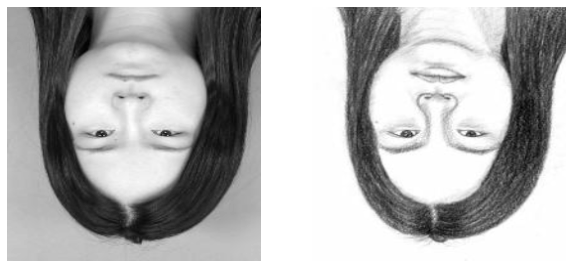

In [8]:
a,b = train_dataset[0]
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(a.T, cmap = 'gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(b.T, cmap = 'gray')
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

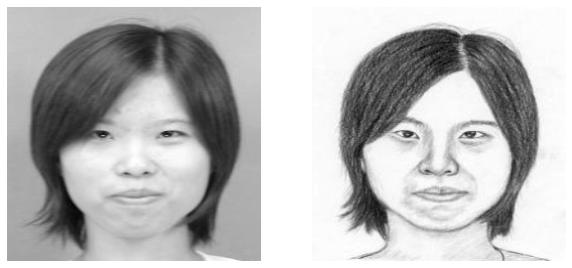

In [9]:
a,b = train_dataset[4]
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(a.T, cmap = 'gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(b.T, cmap = 'gray')
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

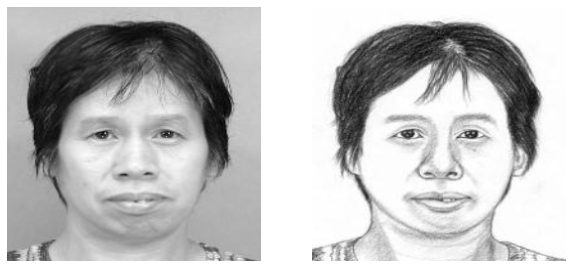

In [10]:
a,b = train_dataset[3]
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(a.T, cmap = 'gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(b.T, cmap = 'gray')
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

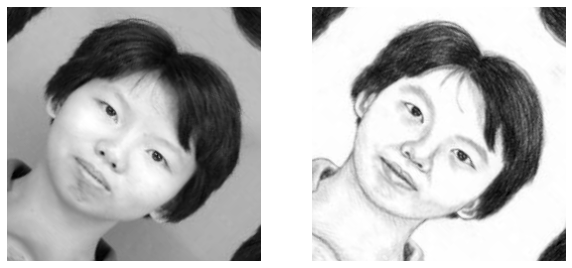

In [11]:
a,b = train_dataset[8]
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(a.T, cmap = 'gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(b.T, cmap = 'gray')
plt.axis('off')

In [12]:
# UNet
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, dropout = False):
        super().__init__()
        self.dropout = dropout
        
        self.down = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.down_dropout = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout()
        )
        
    def forward(self, x):
        if self.dropout:
            x = self.down_dropout(x)
        else:
            x = self.down(x)
        return x

In [13]:
class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout = False):
        super().__init__()
        self.dropout = dropout
        
        self.up = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels,4,2,1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.up_dropout = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels,4,2,1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout()
        )

    def forward(self,x,skip):
        if self.dropout:
            x = self.up_dropout(x)
        else:
            x = self.up(x)
        x = torch.cat((x,skip),1)
        return x

In [14]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=3):
        super().__init__()

        self.down1 = UNetDown(in_channels, 64)
        self.down2 = UNetDown(64,128)                 
        self.down3 = UNetDown(128,256)               
        self.down4 = UNetDown(256,512, dropout=True) 
        self.down5 = UNetDown(512,512,dropout=True)      

        self.up1 = UNetUp(512,512, dropout=True) 
        self.up2 = UNetUp(1024,256)
        self.up3 = UNetUp(512,128)
        self.up4 = UNetUp(256,64)
        self.up5 = nn.Sequential(
            nn.ConvTranspose2d(128,1,4,stride=2,padding=1), 
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)

        u1 = self.up1(d5,d4)
        u2 = self.up2(u1,d3)
        u3 = self.up3(u2,d2)
        u4 = self.up4(u3,d1)
        u5 = self.up5(u4)

        return u5

model = UNet().to(device)

In [15]:
criterion = nn.L1Loss()
# criterion = nn.MSELoss()

from torch import optim
lr = 2e-4

optimizer = optim.Adam(model.parameters(),lr=lr)

In [16]:
num_epochs = 200
start_time = time.time()
flag_loss = 1.5

train_loss_hist = []
validation_loss_hist = []

for epoch in range(num_epochs):
    train_loss = 0
    
    model.train()
    for photo, sketch in train_dl:

        photo = photo.to(device)
        sketch = sketch.to(device)

        model.zero_grad()
        output = model(photo) 
        t_loss = criterion(output, sketch)

        t_loss.backward()
        optimizer.step()

        train_loss+=t_loss.item()
    epoch_loss = train_loss / len(train_dl)
    train_loss_hist.append(epoch_loss)    

    model.eval()
    with torch.no_grad():
        val_loss = 0
        for photo, sketch in test_dl:
            photo = photo.to(device)
            sketch = sketch.to(device)
            
            output = model(photo.to(device))
            
            v_loss = criterion(output,sketch)
            val_loss += v_loss.item()
        val_loss = val_loss / len(test_dl)
        validation_loss_hist.append(val_loss)
       
    print('Epoch: %.0f, train_Loss: %.6f, valid_Loss: %.6f, time: %.2f min' %(epoch, epoch_loss, val_loss, (time.time()-start_time)/60))
    
    if val_loss < flag_loss:
        flag_loss = val_loss
        torch.save(model.state_dict(), '../models/FIANL_model.pt')
        print('--model saved--')


Epoch: 0, train_Loss: 0.742792, valid_Loss: 0.725532, time: 0.06 min
--model saved--
Epoch: 1, train_Loss: 0.520108, valid_Loss: 0.597506, time: 0.08 min
--model saved--
Epoch: 2, train_Loss: 0.457020, valid_Loss: 0.481343, time: 0.10 min
--model saved--
Epoch: 3, train_Loss: 0.425099, valid_Loss: 0.426305, time: 0.13 min
--model saved--
Epoch: 4, train_Loss: 0.410202, valid_Loss: 0.406348, time: 0.15 min
--model saved--
Epoch: 5, train_Loss: 0.402085, valid_Loss: 0.398217, time: 0.17 min
--model saved--
Epoch: 6, train_Loss: 0.393690, valid_Loss: 0.392564, time: 0.19 min
--model saved--
Epoch: 7, train_Loss: 0.390249, valid_Loss: 0.391238, time: 0.22 min
--model saved--
Epoch: 8, train_Loss: 0.386459, valid_Loss: 0.388964, time: 0.24 min
--model saved--
Epoch: 9, train_Loss: 0.376212, valid_Loss: 0.374707, time: 0.26 min
--model saved--
Epoch: 10, train_Loss: 0.358724, valid_Loss: 0.362296, time: 0.29 min
--model saved--
Epoch: 11, train_Loss: 0.334702, valid_Loss: 0.348587, time: 0.3

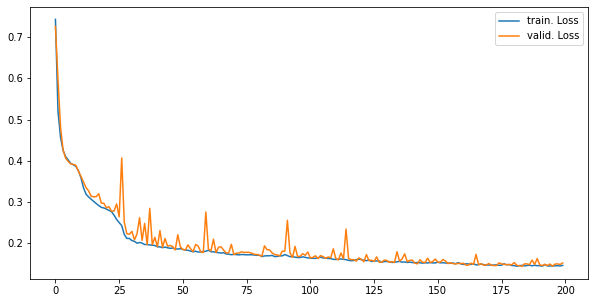

In [17]:
plt.figure(figsize=(10,5))
plt.plot(train_loss_hist, label='train. Loss')
plt.plot(validation_loss_hist, label='valid. Loss')
plt.legend()
plt.show()

In [18]:
model.load_state_dict(torch.load('../models/FIANL_model.pt'))

<All keys matched successfully>

### Train image 학습 확인

In [19]:
model.eval()

with torch.no_grad():
    for photo, sketch in train_dl:
        output = model(photo.to(device)).detach().cpu()
        break

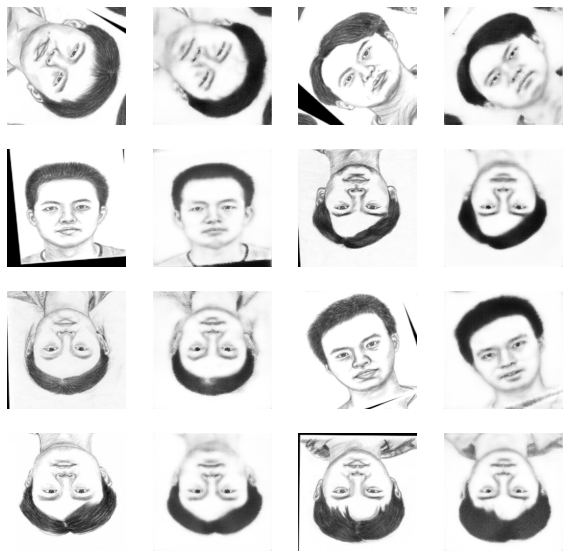

In [20]:
plt.figure(figsize=(10,10))

for ii in range(0,16,2):
    plt.subplot(4,4,ii+1)
    plt.imshow(sketch[ii].T,cmap = 'gray')
    plt.axis('off')
    
    plt.subplot(4,4,ii+2)
    plt.imshow(output[ii].T, cmap = 'gray')
    plt.axis('off')

### validation image 확인

In [21]:
test_ds = Train_dataset('../data/CUHK/test/', transform=valid_transform)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True)

In [22]:
model.eval()

with torch.no_grad():
    for photo, sketch in test_dl:
        output = model(photo.to(device)).detach().cpu()
        break

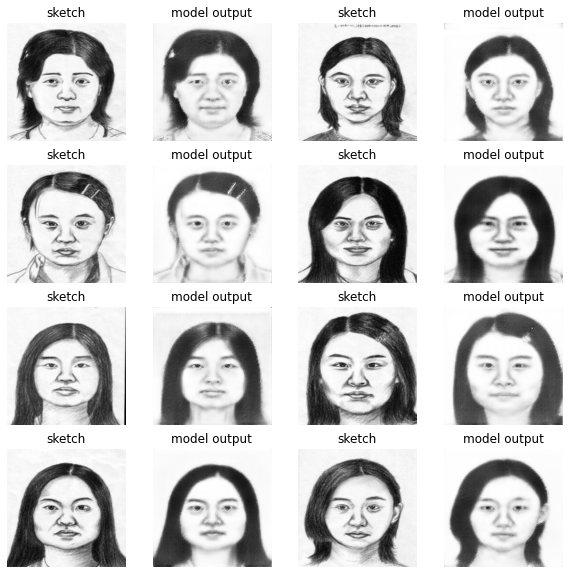

In [23]:
plt.figure(figsize=(10,10))

for ii in range(0,16,2):
    plt.subplot(4,4,ii+1)
    plt.title('sketch')
    plt.imshow(sketch[ii].T, cmap = 'gray')
    plt.axis('off')
    
    plt.subplot(4,4,ii+2)
    plt.title('model output')
    plt.imshow(output[ii].T, cmap = 'gray')
    plt.axis('off')

In [24]:
class Test_dataset(Dataset):
    def __init__(self, path, transform=False):
        super().__init__()
        self.path = path
        self.filenames = os.listdir(path)
        self.transform = transform

    def __getitem__(self, index):
        image = cv2.imread(self.path + self.filenames[index], cv2.IMREAD_GRAYSCALE)
        image = np.expand_dims(image,axis=2)

        if self.transform:
            image = self.transform(image)

        return image

    def __len__(self):
        return len(self.filenames)

In [25]:
test_ds = Test_dataset('../data/CUHK/test/photos/', transform=test_transform)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True)

In [26]:
model.eval()

with torch.no_grad():
    for image in test_dl:
        output = model(image.to(device)).detach().cpu()
        break

In [27]:
length = len(os.listdir('../data/test_image/'))

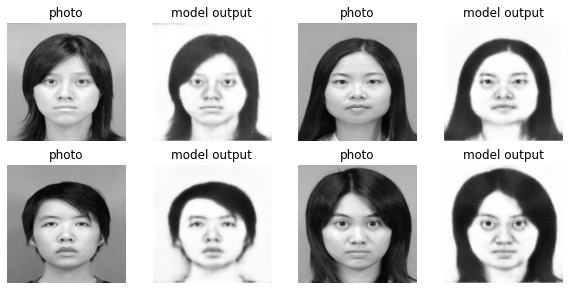

In [28]:
plt.figure(figsize=(10,10))

for ii in range(0,length,2):
    plt.subplot(4,4,ii+1)
    plt.title('photo')
    plt.imshow(image[ii].T.transpose(0,1), cmap = 'gray')
    plt.axis('off')
    
    plt.subplot(4,4,ii+2)
    plt.title('model output')
    plt.imshow(output[ii].T.transpose(0,1), cmap = 'gray')
    plt.axis('off')

### test image 확인

In [29]:
test_ds = Test_dataset('../data/test_image/', transform=test_transform)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True)

In [30]:
length = len(os.listdir('../data/test_image/'))

In [31]:
model.eval()

with torch.no_grad():
    for idx, image in enumerate(test_dl):
        output = model(image.to(device)).detach().cpu()
        
        break

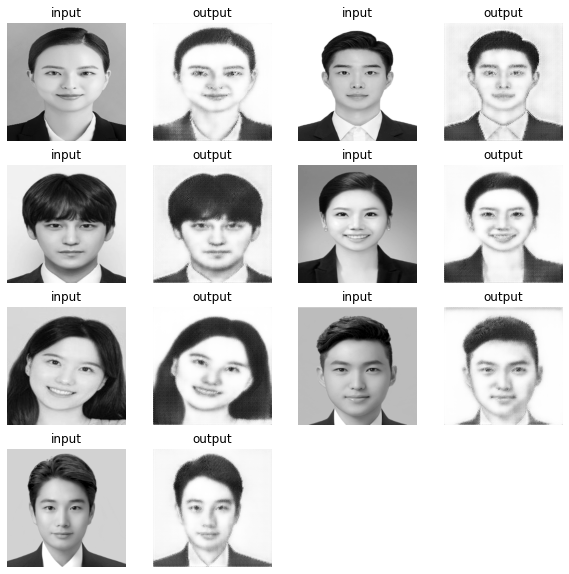

In [34]:
plt.figure(figsize=(10,10))
row = length*2//4 + 1

for idx,ii in enumerate(range(1,length*2,2)):
    plt.subplot(row, 4, ii)
    plt.title('input')
    plt.imshow(image[idx].T.transpose(0,1), cmap = 'gray')
    plt.axis('off')
    
    plt.subplot(row, 4, ii+1)
    plt.title('output')
    plt.imshow(output[idx].T.transpose(0,1), cmap='gray')
    plt.axis('off')
    